In [11]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, plot_tree_leafs_for_class
from tasks.adult import make_task_modified_hours_per_week as make_task
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [12]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:05:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [13]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Local explanations

In [14]:
is_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

## $(False, True)$

In [15]:
focus_class = '(False, True)'

In [16]:
instance_indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
instance_indices

array([2190, 2949, 3925])

In [17]:
comparer.predict_mclass_diff_proba(X[instance_indices, :])

array([[0.26404136, 0.28187937, 0.2196211 , 0.23445816],
       [0.23817219, 0.27045417, 0.23009336, 0.26128033],
       [0.24897155, 0.26827744, 0.23236635, 0.25038466]], dtype=float32)

In [18]:
pd.DataFrame(X[instance_indices], columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,56.0,2.0,10.0,2.0,3.0,4.0,4.0,1.0,0.0,0.0,41.0,39.0
1,47.0,4.0,10.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,45.0,26.0
2,30.0,4.0,11.0,2.0,4.0,4.0,4.0,1.0,0.0,0.0,48.0,39.0


Generating an explanation for a single instance takes 5min. Thus, it is not possible to create a global explanation with this method, as it would take more than 22 days for all instances of the data set. Therefore, I will just create explanations for the instances that are classified different.

In [19]:
(5 * X.shape[0])/60/24

22.614583333333332

In [34]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/3
2/3
3/3
CPU times: user 29min 48s, sys: 3min 49s, total: 33min 38s
Wall time: 14min 59s


In [20]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [21]:
class_names = explanations[0]['class_names']
feature_names = comparer.feature_names

In [22]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


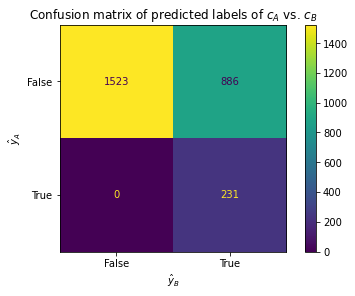

In [23]:
comparer.plot_confusion_matrix(X_explain)

In [24]:
mask = comparer.class_names[comparer.predict_mclass_diff(X_explain)] == focus_class
pd.DataFrame(X_explain[mask], columns=feature_names)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,38.035646,2.218469,13.000000,4.0,3.0,4.0,4.000000,1.000000,0.0,0.0,41.0,39.0
1,41.000000,0.000000,10.028616,2.0,3.0,4.0,4.000000,1.000000,0.0,0.0,41.0,39.0
2,42.000000,2.000000,13.000000,2.0,3.0,4.0,4.000000,0.190051,0.0,0.0,41.0,39.0
3,43.115491,2.000000,13.000000,2.0,3.0,4.0,4.000000,0.190051,0.0,0.0,41.0,39.0
4,44.000000,6.000000,13.363629,2.0,3.0,4.0,4.000000,-0.152204,0.0,0.0,41.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...
881,32.000000,4.000000,11.000000,2.0,4.0,4.0,3.882202,1.000000,0.0,0.0,48.0,39.0
882,33.000000,4.000000,11.000000,2.0,4.0,4.0,3.882202,1.000000,0.0,0.0,48.0,39.0
883,33.000000,4.000000,11.000000,2.0,4.0,4.0,4.000000,1.000000,0.0,0.0,48.0,39.0
884,34.000000,3.981182,10.000000,2.0,4.0,4.0,4.000000,1.000000,0.0,0.0,48.0,39.0


In [25]:
# Check for errors
is_explain_diff = explainer.clf_a.predict(X_explain) != explainer.clf_b.predict(X_explain)
(is_explain_diff != y_explain).sum(), len(y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(0, 2640)

In [26]:
def explain(max_depth=None, tree_fig_size=(28, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    plt.show()
    
    fig, ax = plt.subplots(figsize=(14, 14))
    plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=1)
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=1,
                feature_order=feature_order)
    
    plot_tree_leafs_for_class(tree, class_names, focus_class, X, mclass_diff, comparer.class_names,
                              feature_names)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0],
                                tree.predict(X), target_names=class_names))

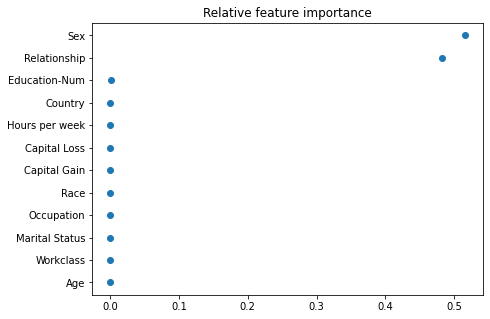

node #6: if (Sex > 0.5) and (Relationship > 3.5) then class (False, True) (covers 0.576 of 1524 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.99      0.63      0.77      1754
    (False, True)       0.58      0.99      0.73       886

         accuracy                           0.75      2640
        macro avg       0.78      0.81      0.75      2640
     weighted avg       0.85      0.75      0.76      2640


original data evaluation:
                   precision    recall  f1-score   support

not (False, True)       1.00      0.60      0.75      6510
    (False, True)       0.00      1.00      0.00         3

         accuracy                           0.60      6513
        macro avg       0.50      0.80      0.38      6513
     weighted avg       1.00      0.60      0.75      6513



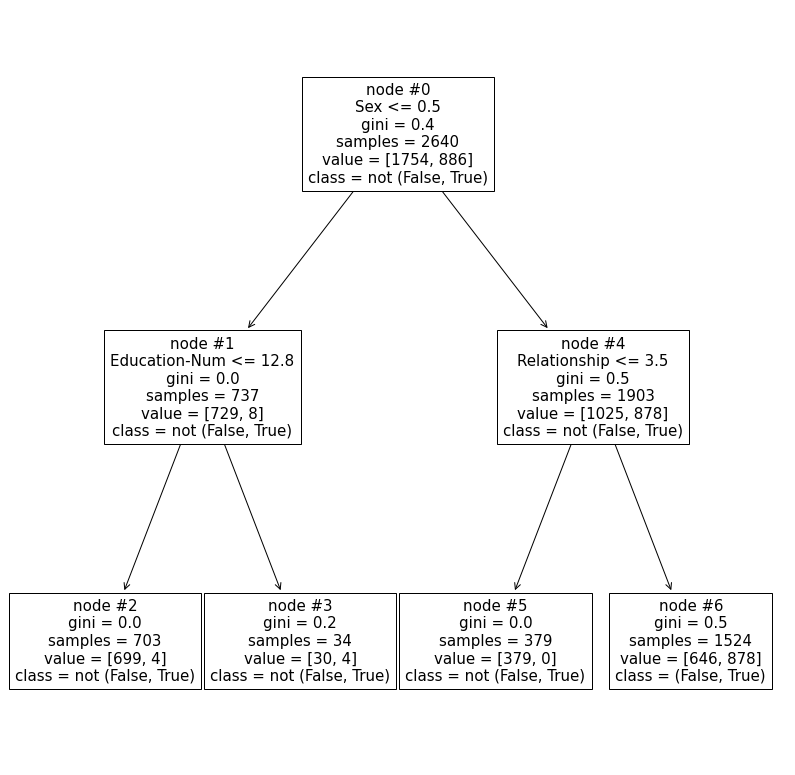

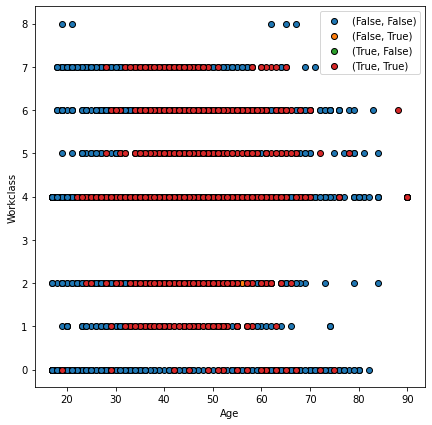

In [27]:
explain(max_depth=2)

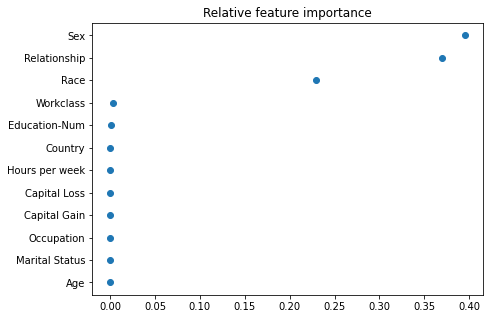

node #12: if (Sex > 0.5) and (Relationship > 3.5) and (Race > 3.5) then class (False, True) (covers 0.652 of 1338 instances)
node #7: if (Sex <= 0.5) and (Workclass > 5.5) and (Education-Num > 12.8) then class (False, True) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.99      0.73      0.84      1754
    (False, True)       0.65      0.99      0.78       886

         accuracy                           0.82      2640
        macro avg       0.82      0.86      0.81      2640
     weighted avg       0.88      0.82      0.82      2640


original data evaluation:
                   precision    recall  f1-score   support

not (False, True)       1.00      0.63      0.77      6510
    (False, True)       0.00      1.00      0.00         3

         accuracy                           0.63      6513
        macro avg       0.50      0.81      0.39      6513
     weighted avg       1.00      0.63 

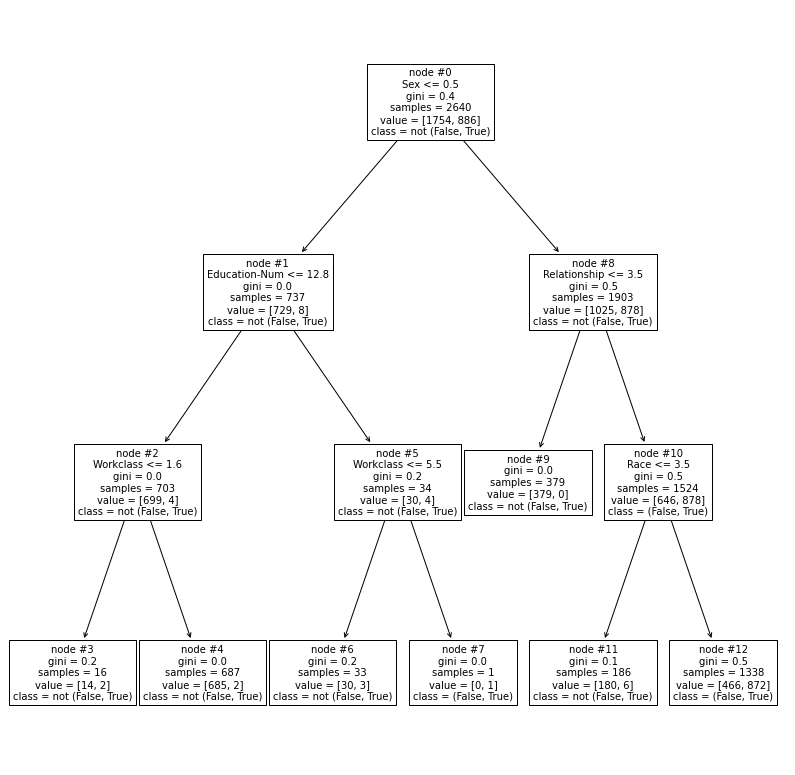

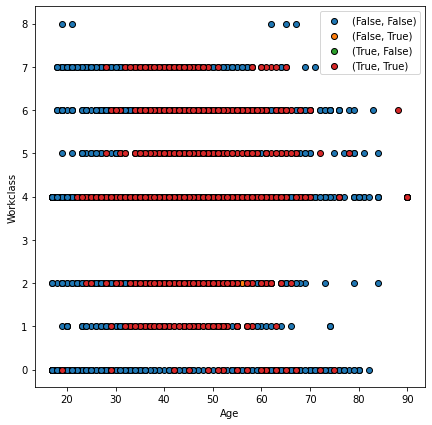

In [28]:
explain(max_depth=3)

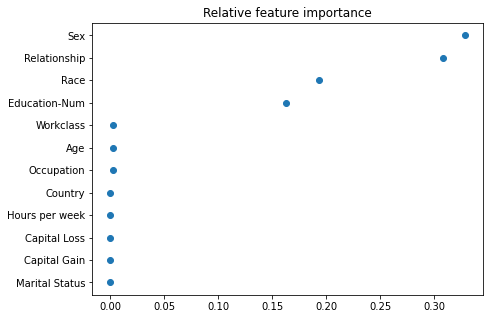

node #22: if (Sex > 0.5) and (Relationship > 3.5) and (Race > 3.5) and (Education-Num > 9.5) then class (False, True) (covers 0.716 of 1213 instances)
node #13: if (Sex <= 0.5) and (Education-Num > 12.8) and (Workclass > 5.5) then class (False, True) (covers 1.0 of 1 instances)
node #12: if (Sex <= 0.5) and (Education-Num > 12.8) and (Workclass <= 5.5) and (Age > 62.0) then class (False, True) (covers 1.0 of 1 instances)
node #5: if (Sex <= 0.5) and (Education-Num <= 12.8) and (Workclass <= 1.6) and (Occupation > 7.5) then class (False, True) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.99      0.80      0.89      1754
    (False, True)       0.72      0.98      0.83       886

         accuracy                           0.86      2640
        macro avg       0.85      0.89      0.86      2640
     weighted avg       0.90      0.86      0.87      2640


original data evaluation:
           

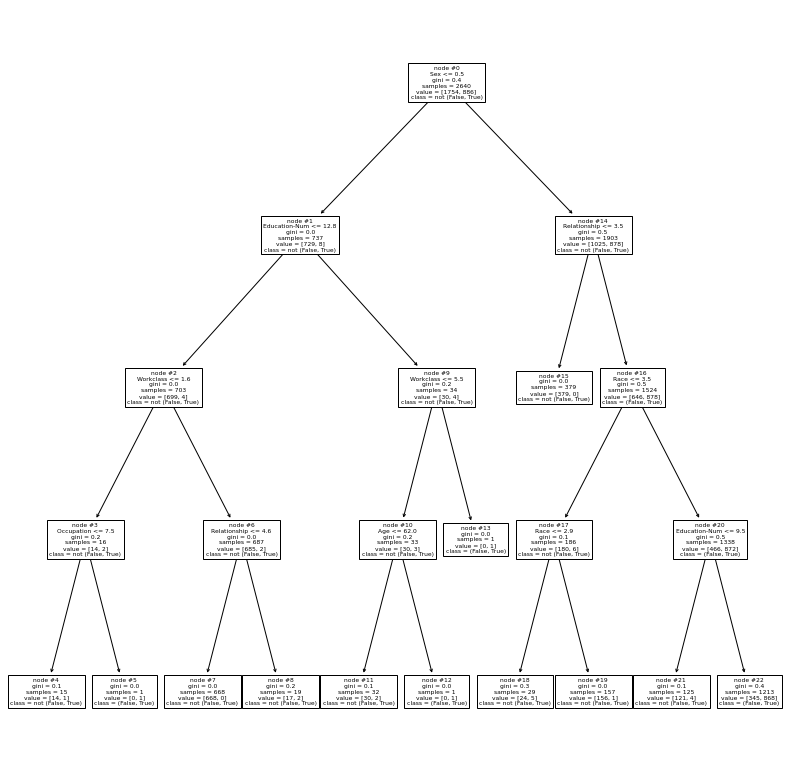

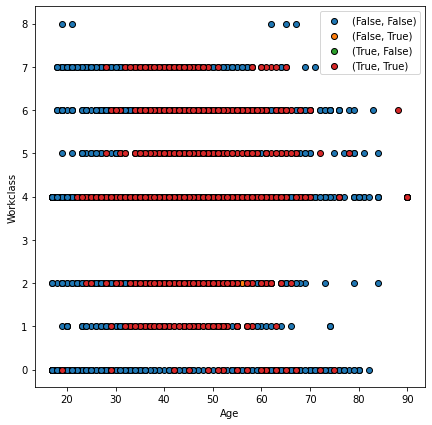

In [29]:
explain(max_depth=4)

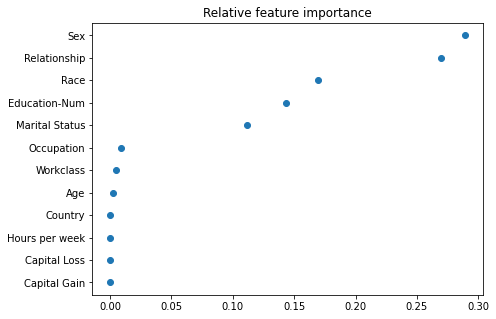

node #35: if (Sex > 0.5) and (Relationship > 3.5) and (Race > 3.5) and (Education-Num > 9.5) and (Marital Status <= 2.7) then class (False, True) (covers 0.775 of 1098 instances)
node #26: if (Sex > 0.5) and (Relationship > 3.5) and (Race <= 2.9) and (Occupation > 7.5) then class (False, True) (covers 1.0 of 3 instances)
node #18: if (Sex <= 0.5) and (Education-Num > 12.8) and (Workclass > 5.5) and (Age <= 62.0) then class (False, True) (covers 1.0 of 1 instances)
node #12: if (Sex <= 0.5) and (Relationship > 4.6) and (Education-Num <= 12.8) and (Marital Status > 3.5) and (Workclass > 1.6) then class (False, True) (covers 1.0 of 1 instances)
node #7: if (Sex <= 0.5) and (Education-Num <= 12.8) and (Workclass > 1.1) and (Workclass <= 1.6) then class (False, True) (covers 1.0 of 1 instances)
node #6: if (Sex <= 0.5) and (Education-Num <= 12.8) and (Occupation > 7.5) and (Workclass <= 1.1) then class (False, True) (covers 1.0 of 1 instances)
node #19: if (Sex <= 0.5) and (Education-Num > 

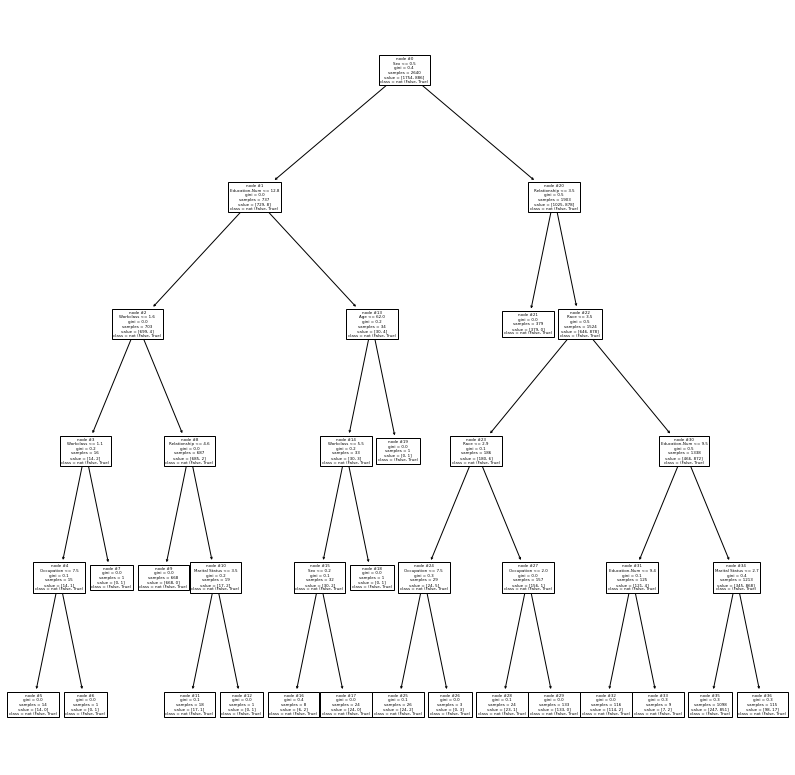

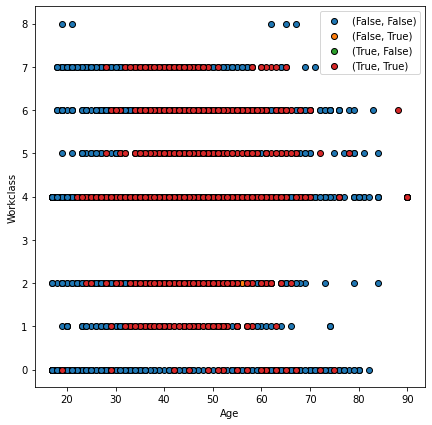

In [30]:
explain(max_depth=5)

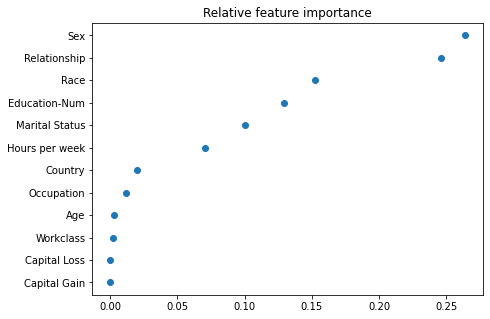

node #49: if (Sex > 0.5) and (Relationship > 3.5) and (Race > 3.5) and (Education-Num > 9.5) and (Marital Status <= 2.7) and (Hours per week > 40.7) then class (False, True) (covers 0.81 of 1051 instances)
node #51: if (Sex > 0.5) and (Relationship > 3.5) and (Race > 3.5) and (Education-Num > 9.5) and (Marital Status > 2.7) and (Country <= 31.0) then class (False, True) (covers 0.812 of 16 instances)
node #21: if (Sex > 0.1) and (Sex <= 0.2) and (Education-Num > 12.8) and (Age <= 62.0) then class (False, True) (covers 0.667 of 3 instances)
node #31: if (Sex > 0.5) and (Relationship > 4.3) and (Race <= 2.9) and (Occupation <= 7.5) then class (False, True) (covers 0.667 of 3 instances)
node #32: if (Sex > 0.5) and (Relationship > 3.5) and (Race <= 2.9) and (Occupation > 7.5) then class (False, True) (covers 1.0 of 3 instances)
node #45: if (Sex > 0.5) and (Relationship > 3.5) and (Race > 3.5) and (Education-Num > 9.4) and (Education-Num <= 9.5) and (Occupation > 3.3) then class (False, T

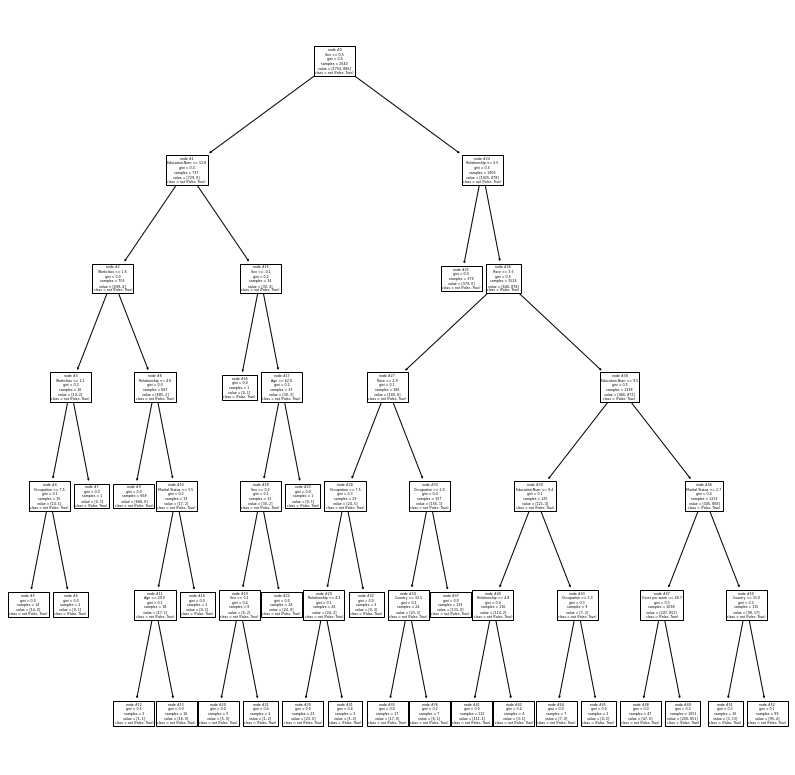

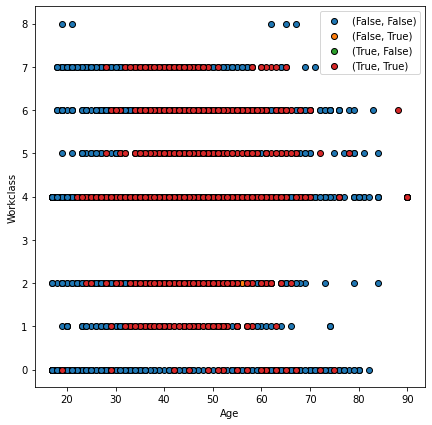

In [31]:
explain(max_depth=6)

For increasing tree depth, I observe that the rule with the highest coverage is getting more detailled. Further smaller rules are added as well, but the majority is explained by just one rule. Still, none of the rules explains any of the instances in the original data set.

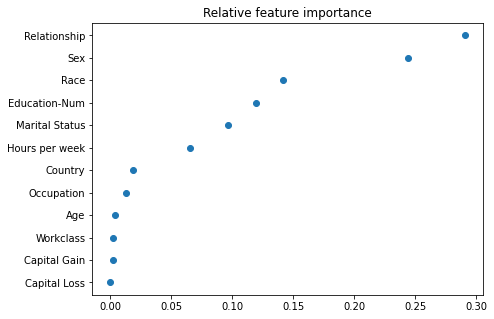

node #62: if (Relationship > 3.5) and (Relationship <= 4.5) and (Sex > 0.5) and (Race > 3.5) and (Education-Num > 9.5) and (Marital Status <= 2.7) and (Hours per week > 40.7) then class (False, True) (covers 0.857 of 971 instances)
node #66: if (Relationship > 3.5) and (Sex > 0.5) and (Race > 3.5) and (Education-Num > 9.5) and (Marital Status > 2.7) and (Marital Status <= 3.5) and (Country <= 31.0) then class (False, True) (covers 1.0 of 12 instances)
node #38: if (Relationship > 3.5) and (Sex > 0.5) and (Race <= 2.9) and (Occupation > 7.5) then class (False, True) (covers 1.0 of 3 instances)
node #57: if (Relationship > 3.5) and (Sex > 0.5) and (Race > 3.5) and (Education-Num > 9.4) and (Education-Num <= 9.5) and (Occupation > 3.3) then class (False, True) (covers 1.0 of 2 instances)
node #24: if (Sex > 0.1) and (Sex <= 0.2) and (Education-Num > 12.8) and (Age <= 49.6) then class (False, True) (covers 1.0 of 2 instances)
node #36: if (Relationship > 4.3) and (Sex > 0.5) and (Race <= 2

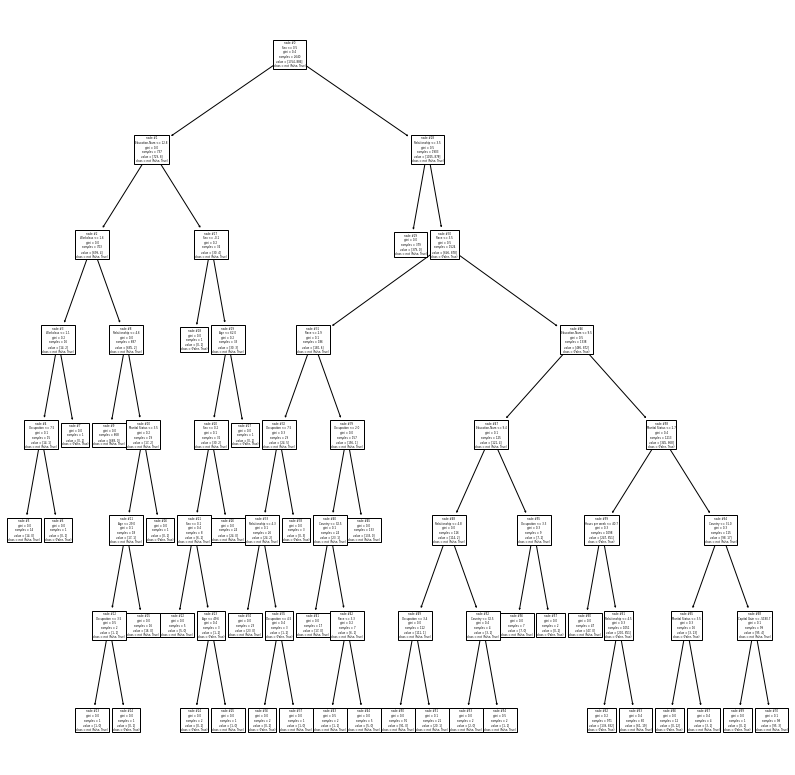

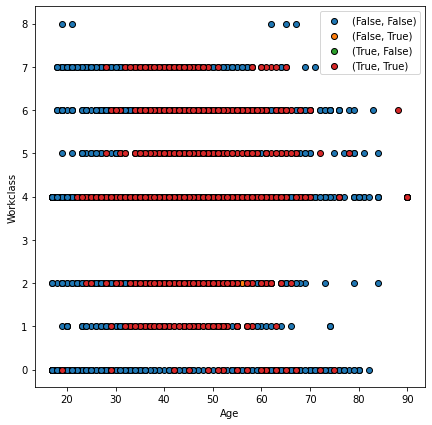

In [32]:
explain(max_depth=7)

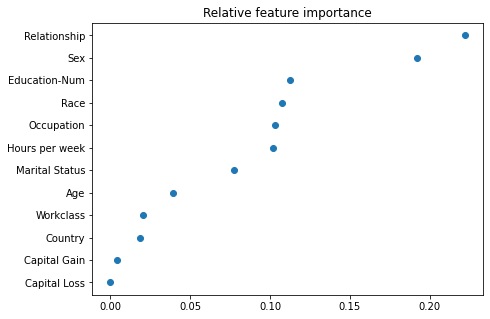

node #137: if (Relationship > 3.5) and (Relationship <= 4.5) and (Sex > 1.0) and (Education-Num > 9.5) and (Race > 3.5) and (Occupation > 0.6) and (Occupation <= 4.1) and (Hours per week > 40.7) and (Hours per week <= 48.5) and (Marital Status <= 2.7) and (Age > 29.5) and (Age <= 64.0) and (Workclass > 1.4) and (Workclass <= 5.6) and (Capital Gain <= 543.0) then class (False, True) (covers 1.0 of 144 instances)
node #125: if (Relationship > 3.5) and (Relationship <= 4.5) and (Sex > 1.0) and (Sex <= 1.0) and (Education-Num > 10.0) and (Race > 3.5) and (Occupation > 0.6) and (Occupation <= 4.1) and (Hours per week > 40.7) and (Hours per week <= 48.5) and (Marital Status <= 2.7) and (Age > 29.5) and (Age <= 64.0) and (Workclass > 1.4) and (Workclass <= 4.0) and (Capital Gain <= 543.0) then class (False, True) (covers 1.0 of 120 instances)
node #111: if (Relationship > 3.5) and (Relationship <= 4.5) and (Sex > 1.0) and (Sex <= 1.0) and (Education-Num > 9.5) and (Education-Num <= 10.0) and 

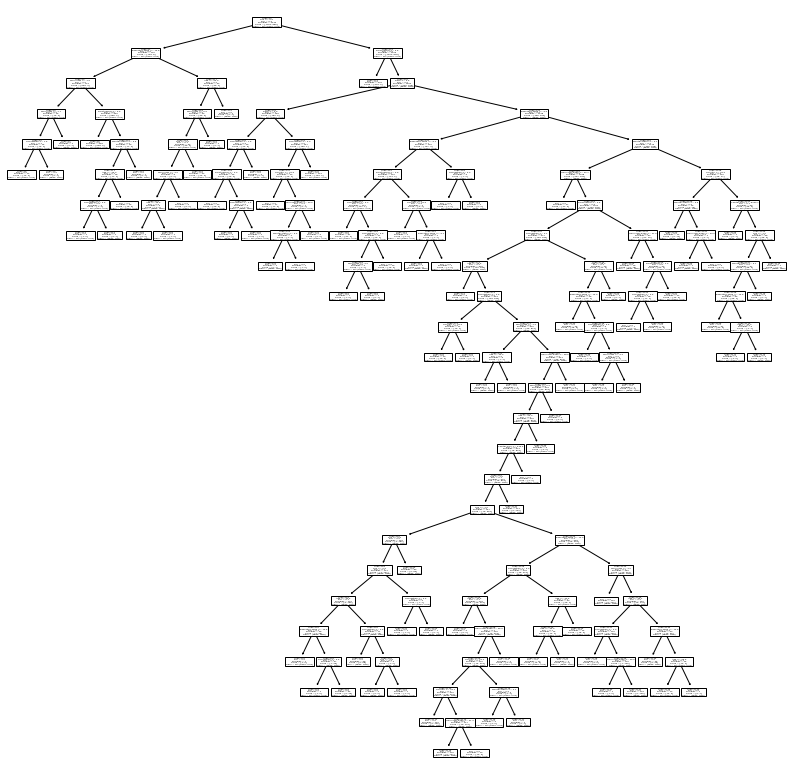

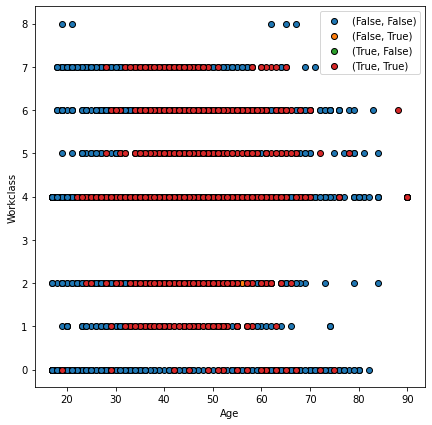

In [33]:
explain()

Not even the fully expanded tree explains the three instances (0% precision on original data set)

## $(True, False)$

In [34]:
focus_class = '(True, False)'

In [35]:
instance_indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
instance_indices

array([5992])

In [36]:
comparer.predict_mclass_diff_proba(X[instance_indices, :])

array([[0.24376692, 0.24279086, 0.2572361 , 0.25620613]], dtype=float32)

In [37]:
pd.DataFrame(X[instance_indices], columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,35.0,4.0,13.0,2.0,5.0,4.0,4.0,1.0,0.0,0.0,65.0,41.0


In [84]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/1
CPU times: user 10min 38s, sys: 1min 16s, total: 11min 55s
Wall time: 5min 11s


In [38]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [39]:
class_names = explanations[0]['class_names']
feature_names = comparer.feature_names

In [40]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


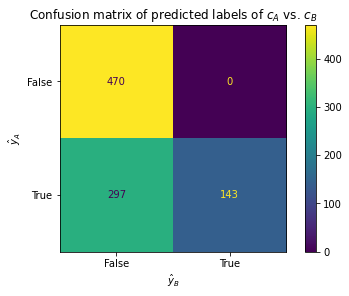

In [41]:
comparer.plot_confusion_matrix(X_explain)

In [42]:
mask = comparer.class_names[comparer.predict_mclass_diff(X_explain)] == focus_class
pd.DataFrame(X_explain[mask], columns=feature_names)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,34.000000,4.000000,12.723688,2.000000,5.0,4.000000,4.000000,1.000000,0.0,0.0,65.0,41.0
1,34.000000,4.000000,12.861021,2.000000,5.0,4.000000,4.000000,1.000000,0.0,0.0,65.0,41.0
2,34.000000,4.000000,13.000000,1.803237,5.0,4.000000,4.000000,1.000000,0.0,0.0,65.0,41.0
3,34.000000,4.000000,13.000000,2.000000,5.0,3.787611,4.000000,1.000000,0.0,0.0,65.0,41.0
4,34.000000,4.000000,13.000000,2.000000,5.0,4.000000,3.819428,1.000000,0.0,0.0,65.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
292,35.000000,5.000000,13.017689,2.000000,5.0,4.000000,4.000000,1.000000,0.0,0.0,65.0,41.0
293,39.191589,4.000000,13.000000,2.665151,5.0,4.000000,4.000000,1.000000,0.0,0.0,65.0,41.0
294,47.000000,5.640261,13.000000,2.000000,3.0,4.000000,4.000000,0.333368,0.0,0.0,65.0,41.0
295,50.000000,4.000000,13.000000,2.000000,14.0,4.000000,4.000000,0.333368,0.0,0.0,65.0,41.0


In [43]:
# Check for errors
is_explain_diff = explainer.clf_a.predict(X_explain) != explainer.clf_b.predict(X_explain)
(is_explain_diff != y_explain).sum(), len(y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(0, 910)

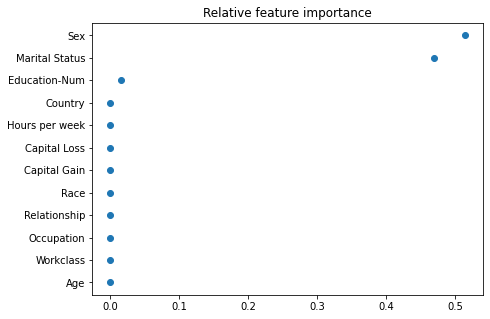

node #5: if (Sex > 0.5) and (Marital Status <= 2.5) then class (True, False) (covers 0.617 of 472 instances)
node #3: if (Sex <= 0.5) and (Education-Num > 14.5) then class (True, False) (covers 0.667 of 3 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.70      0.82       613
    (True, False)       0.62      0.99      0.76       297

         accuracy                           0.80       910
        macro avg       0.80      0.84      0.79       910
     weighted avg       0.87      0.80      0.80       910


original data evaluation:
                   precision    recall  f1-score   support

not (True, False)       1.00      0.54      0.70      6512
    (True, False)       0.00      1.00      0.00         1

         accuracy                           0.54      6513
        macro avg       0.50      0.77      0.35      6513
     weighted avg       1.00      0.54      0.70      6513



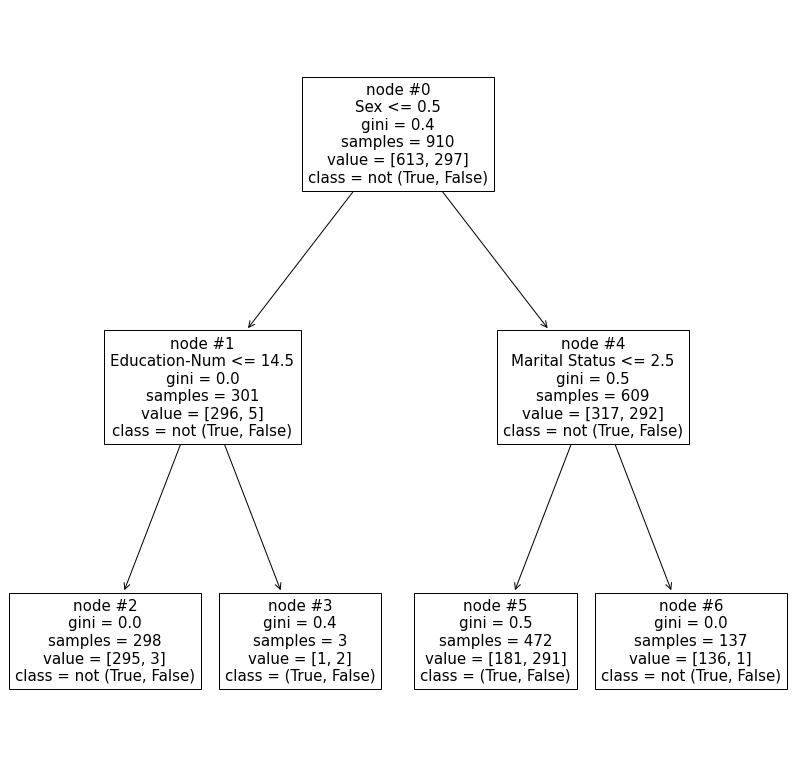

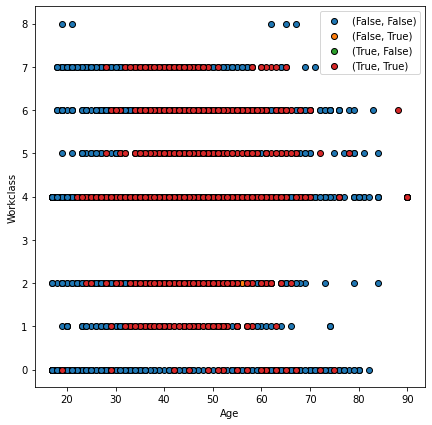

In [44]:
explain(max_depth=2)

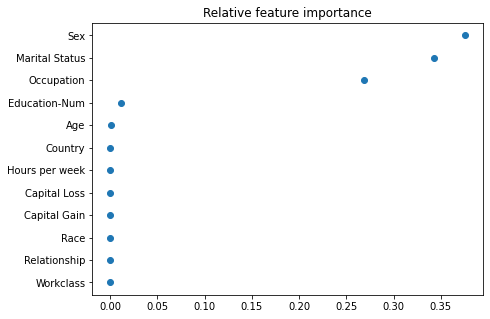

node #10: if (Sex > 0.5) and (Marital Status <= 2.5) and (Occupation <= 5.5) then class (True, False) (covers 0.724 of 399 instances)
node #7: if (Sex <= 0.5) and (Occupation > 4.5) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.82      0.90       613
    (True, False)       0.73      0.98      0.83       297

         accuracy                           0.87       910
        macro avg       0.86      0.90      0.87       910
     weighted avg       0.90      0.87      0.88       910


original data evaluation:
                   precision    recall  f1-score   support

not (True, False)       1.00      0.77      0.87      6512
    (True, False)       0.00      1.00      0.00         1

         accuracy                           0.77      6513
        macro avg       0.50      0.89      0.44      6513
     weighted avg       1.00 

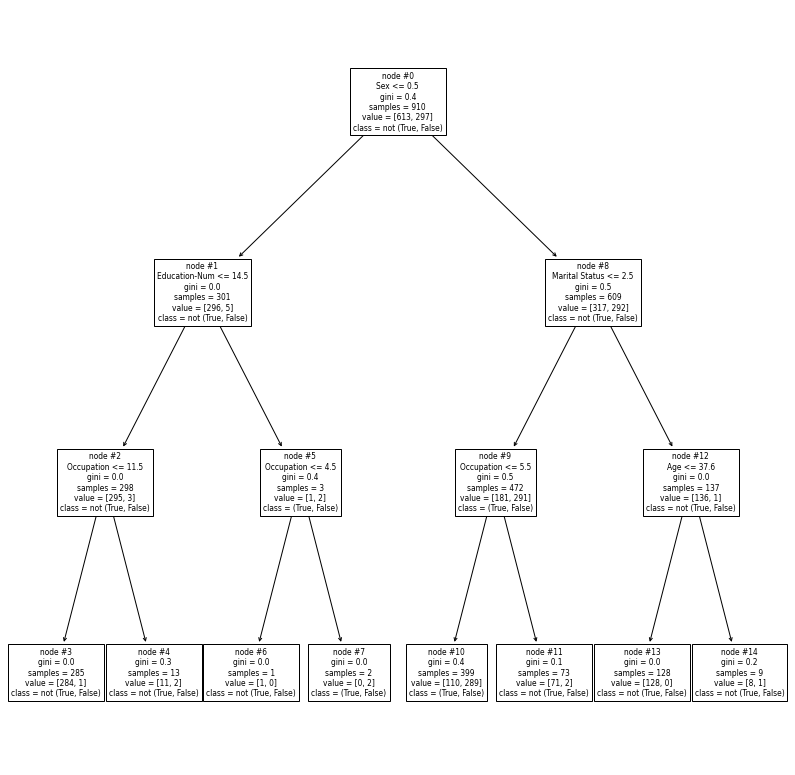

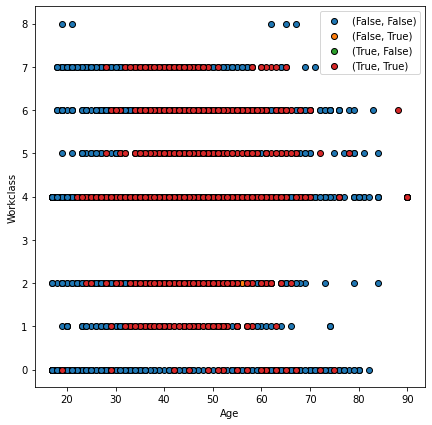

In [45]:
explain(max_depth=3)

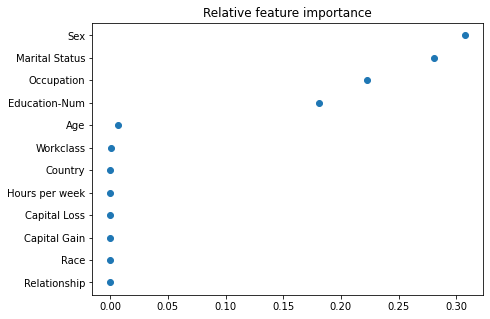

node #16: if (Sex > 0.5) and (Marital Status <= 2.5) and (Occupation <= 5.5) and (Education-Num > 12.7) then class (True, False) (covers 0.805 of 359 instances)
node #11: if (Sex <= 0.5) and (Occupation > 4.5) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #23: if (Sex > 0.5) and (Marital Status > 2.5) and (Age > 37.6) and (Age <= 40.1) then class (True, False) (covers 1.0 of 1 instances)
node #8: if (Sex <= 0.5) and (Occupation > 11.5) and (Education-Num > 13.0) and (Education-Num <= 14.5) then class (True, False) (covers 1.0 of 1 instances)

generated data evaluation:
                   precision    recall  f1-score   support

not (True, False)       0.99      0.89      0.94       613
    (True, False)       0.81      0.99      0.89       297

         accuracy                           0.92       910
        macro avg       0.90      0.94      0.91       910
     weighted avg       0.93      0.92      0.92       910


original data evaluation:
 

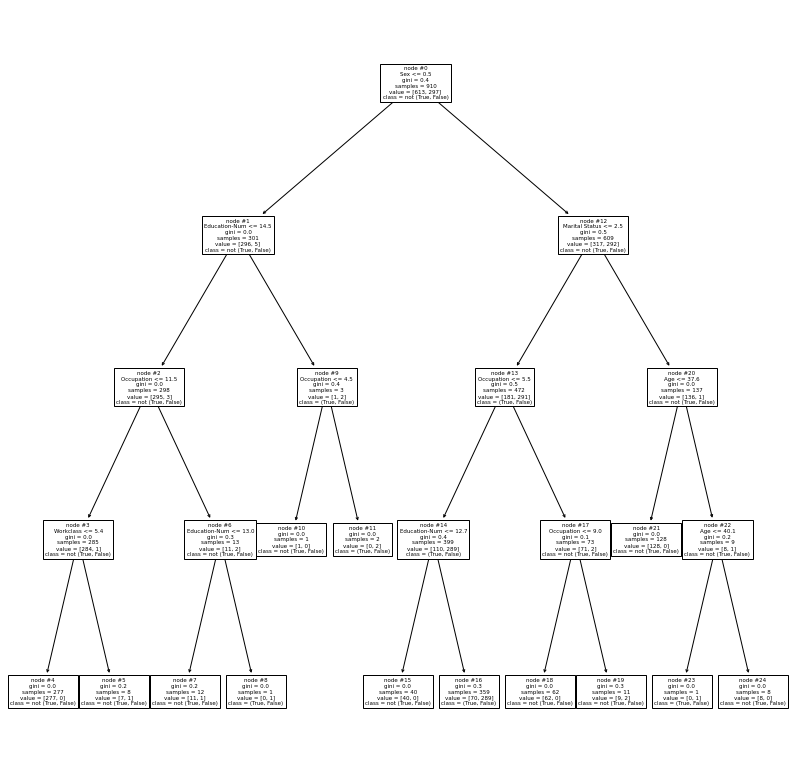

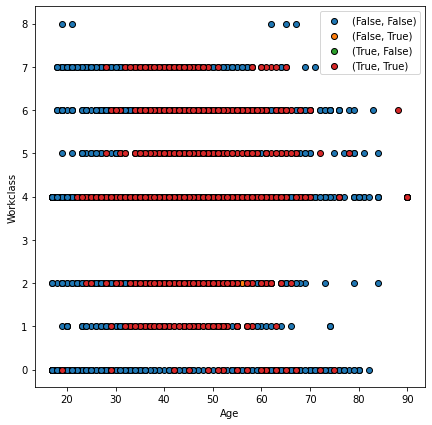

In [46]:
explain(max_depth=4)

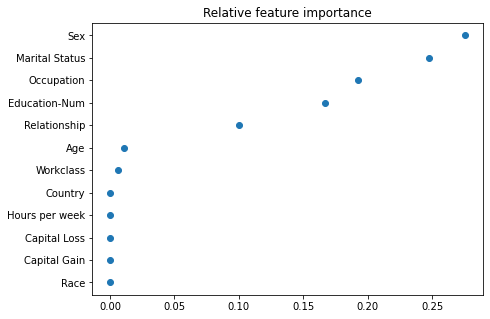

node #22: if (Sex > 0.5) and (Marital Status <= 2.5) and (Occupation <= 5.5) and (Education-Num > 12.7) and (Relationship > 3.4) then class (True, False) (covers 0.86 of 336 instances)
node #26: if (Sex > 0.5) and (Marital Status <= 2.5) and (Occupation > 9.0) and (Education-Num <= 12.7) then class (True, False) (covers 0.667 of 3 instances)
node #14: if (Sex <= 0.4) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #31: if (Sex > 0.5) and (Marital Status > 2.5) and (Age > 37.6) and (Age <= 40.1) then class (True, False) (covers 1.0 of 1 instances)
node #12: if (Sex <= 0.5) and (Occupation > 11.5) and (Education-Num <= 14.5) and (Age > 43.5) then class (True, False) (covers 1.0 of 1 instances)
node #11: if (Sex <= 0.5) and (Occupation > 11.5) and (Education-Num > 13.0) and (Education-Num <= 14.5) and (Age <= 43.5) then class (True, False) (covers 1.0 of 1 instances)
node #6: if (Sex <= 0.5) and (Occupation <= 11.5) and (Education-Num <= 14.5) and (Wor

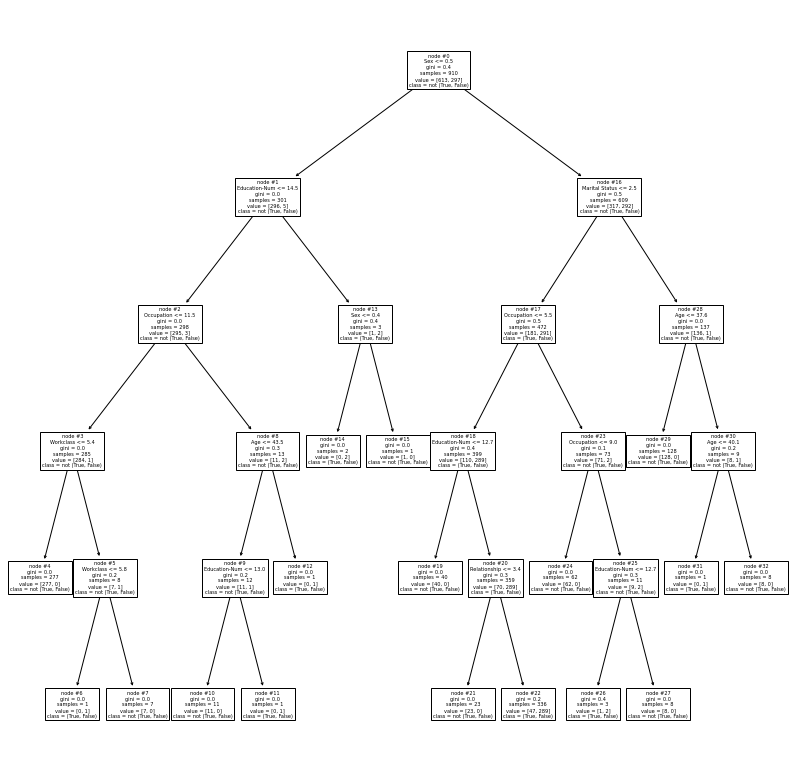

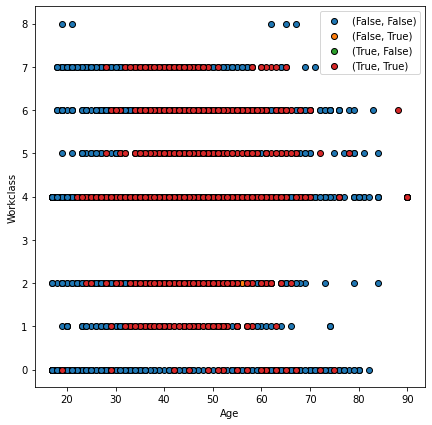

In [47]:
explain(max_depth=5)

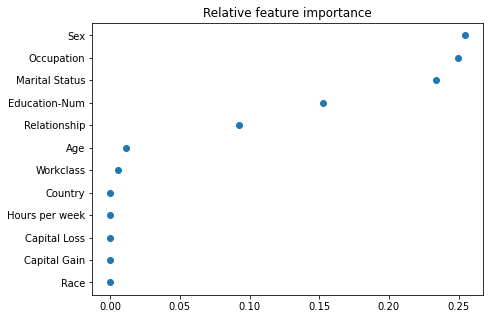

node #24: if (Sex > 0.5) and (Occupation > 4.7) and (Occupation <= 5.5) and (Marital Status <= 2.5) and (Education-Num > 12.7) and (Relationship > 3.4) then class (True, False) (covers 0.903 of 320 instances)
node #30: if (Sex > 0.5) and (Occupation > 9.0) and (Marital Status <= 2.5) and (Education-Num > 10.0) and (Education-Num <= 12.7) then class (True, False) (covers 1.0 of 2 instances)
node #14: if (Sex <= 0.4) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #35: if (Sex > 0.5) and (Marital Status > 2.5) and (Age > 37.6) and (Age <= 40.1) then class (True, False) (covers 1.0 of 1 instances)
node #12: if (Sex <= 0.5) and (Occupation > 11.5) and (Marital Status > 2.8) and (Education-Num <= 14.5) then class (True, False) (covers 1.0 of 1 instances)
node #11: if (Sex <= 0.5) and (Occupation > 11.5) and (Marital Status <= 2.8) and (Education-Num <= 14.5) and (Age > 43.5) then class (True, False) (covers 1.0 of 1 instances)
node #6: if (Sex <= 0.5) an

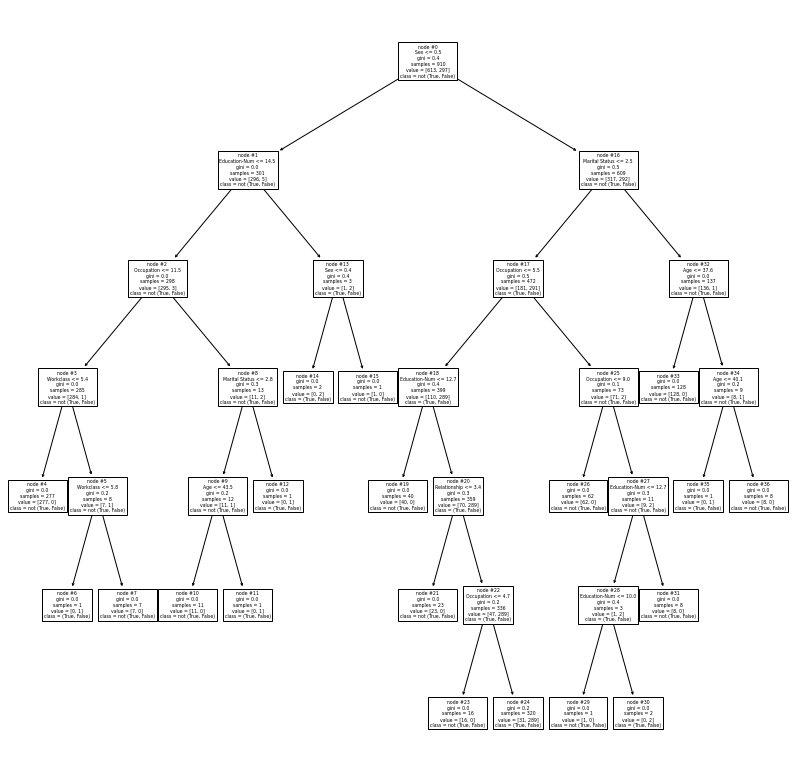

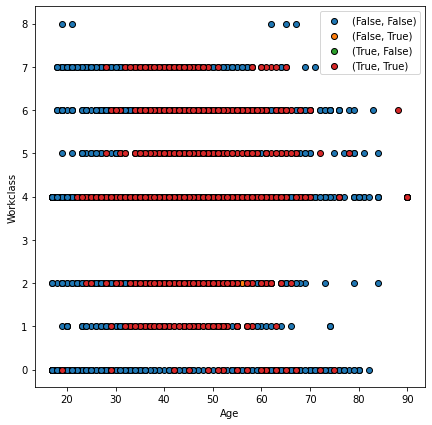

In [48]:
explain(max_depth=6)

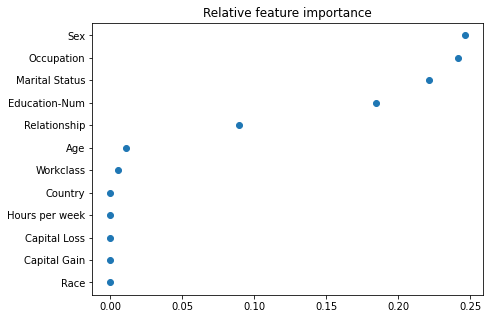

node #25: if (Sex > 0.5) and (Occupation > 4.7) and (Occupation <= 5.5) and (Marital Status <= 2.5) and (Education-Num > 12.7) and (Education-Num <= 13.7) and (Relationship > 3.4) then class (True, False) (covers 0.923 of 313 instances)
node #32: if (Sex > 0.5) and (Occupation > 9.0) and (Marital Status <= 2.5) and (Education-Num > 10.0) and (Education-Num <= 12.7) then class (True, False) (covers 1.0 of 2 instances)
node #14: if (Sex <= 0.4) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #37: if (Sex > 0.5) and (Marital Status > 2.5) and (Age > 37.6) and (Age <= 40.1) then class (True, False) (covers 1.0 of 1 instances)
node #12: if (Sex <= 0.5) and (Occupation > 11.5) and (Education-Num > 13.0) and (Education-Num <= 14.5) then class (True, False) (covers 1.0 of 1 instances)
node #11: if (Sex <= 0.5) and (Occupation > 11.5) and (Education-Num <= 13.0) and (Age > 43.5) then class (True, False) (covers 1.0 of 1 instances)
node #6: if (Sex <= 0.5) an

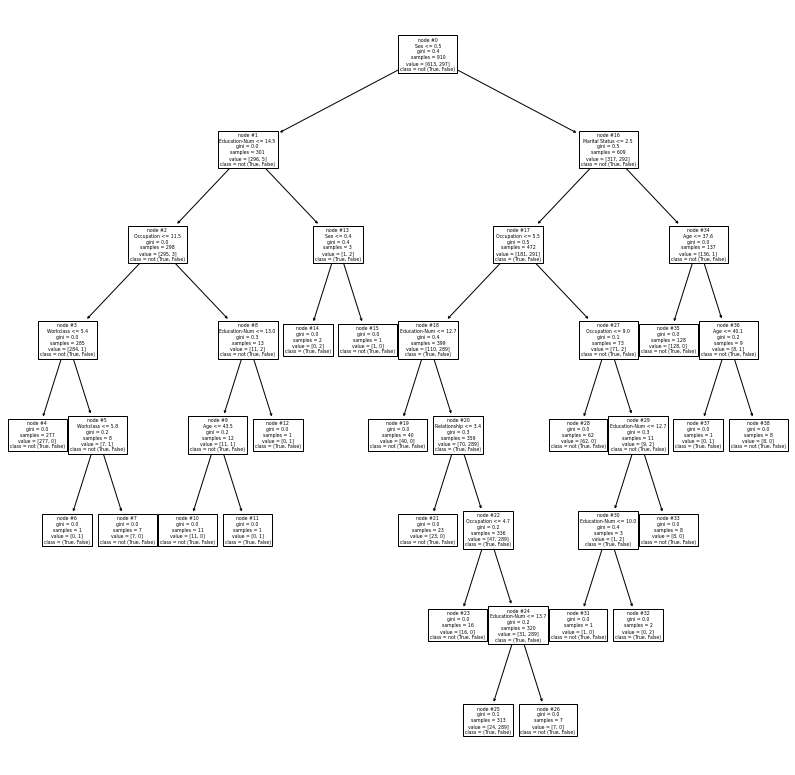

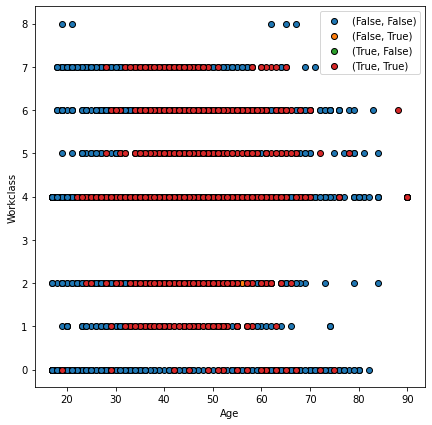

In [49]:
explain(max_depth=7)

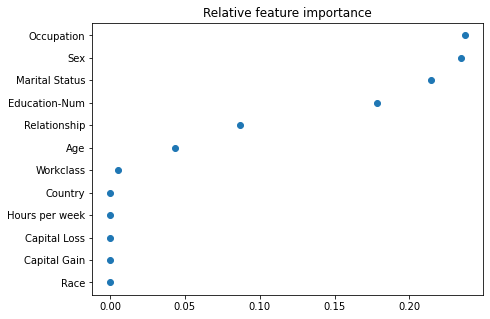

node #26: if (Occupation > 4.7) and (Occupation <= 5.5) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 12.7) and (Education-Num <= 13.7) and (Relationship > 3.4) and (Age <= 35.5) then class (True, False) (covers 0.947 of 304 instances)
node #34: if (Occupation > 9.0) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 10.0) and (Education-Num <= 12.7) then class (True, False) (covers 1.0 of 2 instances)
node #15: if (Occupation > 4.5) and (Sex <= 0.5) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #39: if (Sex > 0.5) and (Marital Status > 2.5) and (Age > 37.6) and (Age <= 40.1) then class (True, False) (covers 1.0 of 1 instances)
node #12: if (Occupation > 11.5) and (Sex <= 0.5) and (Education-Num > 13.0) and (Education-Num <= 14.5) then class (True, False) (covers 1.0 of 1 instances)
node #11: if (Occupation > 11.5) and (Sex <= 0.5) and (Education-Num <= 13.0) and (Age > 43.5) then class (True, False) (covers 1.0 of

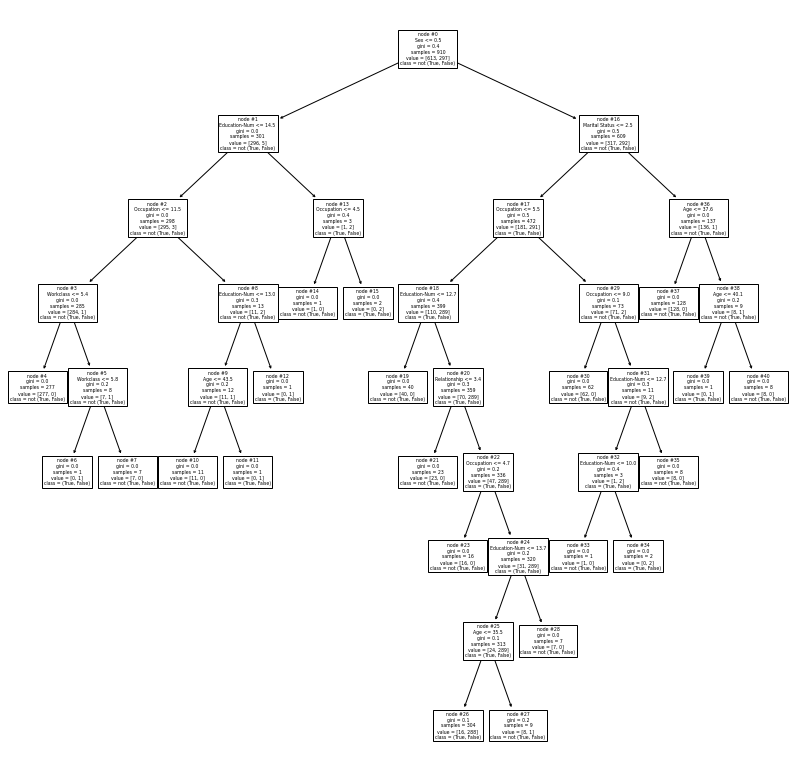

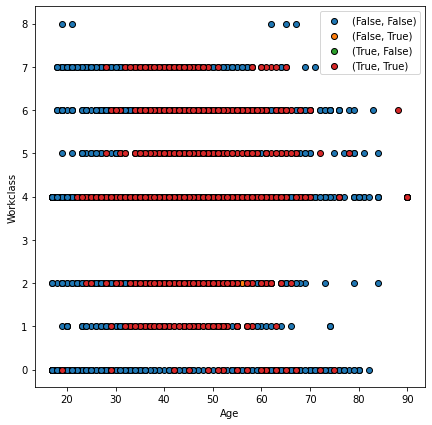

In [50]:
explain(max_depth=8)

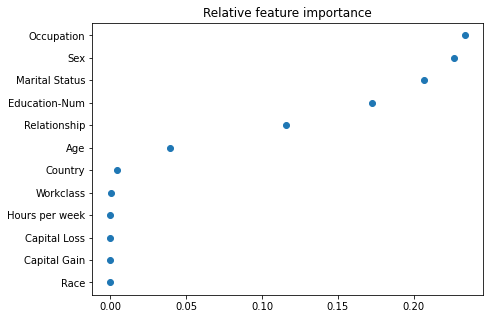

node #27: if (Occupation > 4.7) and (Occupation <= 5.5) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 12.7) and (Education-Num <= 13.7) and (Relationship > 3.4) and (Relationship <= 4.1) and (Age <= 35.5) then class (True, False) (covers 0.97 of 296 instances)
node #38: if (Occupation > 9.0) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 10.0) and (Education-Num <= 12.7) then class (True, False) (covers 1.0 of 2 instances)
node #15: if (Occupation > 4.5) and (Sex <= 0.5) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #30: if (Occupation > 4.7) and (Occupation <= 5.5) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 12.7) and (Education-Num <= 13.7) and (Relationship > 4.1) and (Country <= 37.0) then class (True, False) (covers 1.0 of 1 instances)
node #43: if (Sex > 0.5) and (Marital Status > 2.5) and (Age > 37.6) and (Age <= 40.1) then class (True, False) (covers 1.0 of 1 instances)
node #12: if

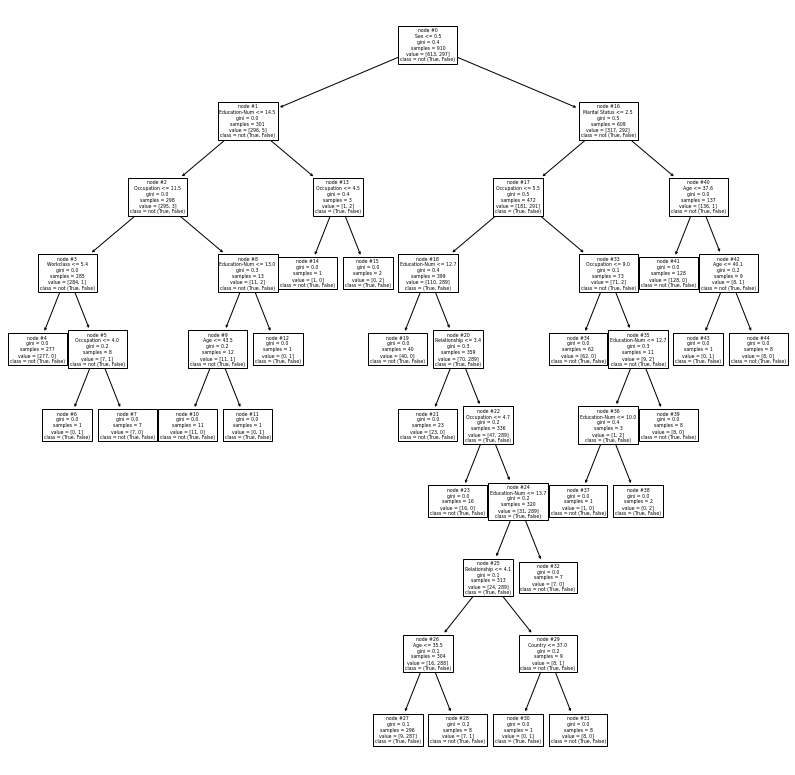

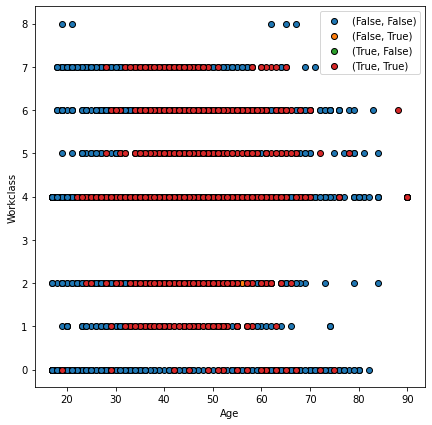

In [51]:
explain(max_depth=9)

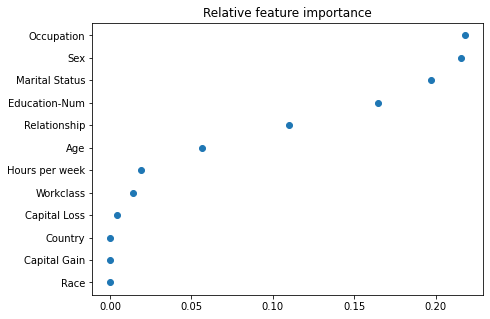

node #33: if (Occupation > 4.7) and (Occupation <= 5.5) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 12.7) and (Education-Num <= 13.7) and (Relationship > 3.4) and (Relationship <= 4.1) and (Age > 32.0) and (Age <= 35.5) and (Hours per week > 62.8) and (Workclass > 1.0) then class (True, False) (covers 1.0 of 287 instances)
node #46: if (Occupation > 9.0) and (Sex > 0.5) and (Marital Status <= 2.5) and (Education-Num > 10.0) and (Education-Num <= 12.7) then class (True, False) (covers 1.0 of 2 instances)
node #15: if (Occupation > 4.5) and (Sex <= 0.5) and (Education-Num > 14.5) then class (True, False) (covers 1.0 of 2 instances)
node #12: if (Occupation > 11.5) and (Sex <= 0.5) and (Education-Num <= 14.5) and (Age > 43.5) then class (True, False) (covers 1.0 of 1 instances)
node #6: if (Occupation <= 11.5) and (Sex <= 0.5) and (Education-Num <= 14.5) and (Workclass > 5.4) and (Workclass <= 5.8) then class (True, False) (covers 1.0 of 1 instances)
node #11: if (Occ

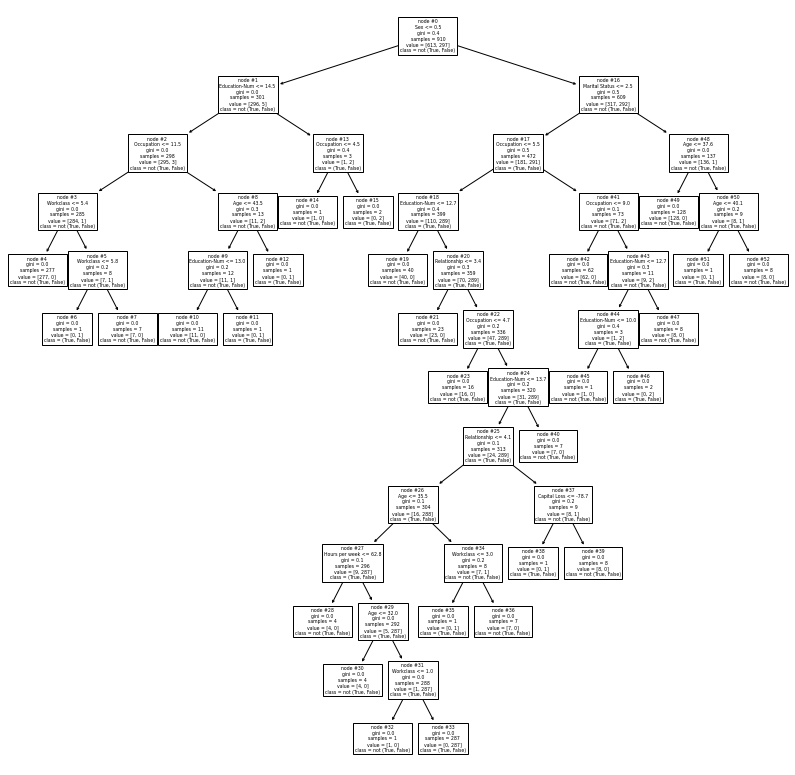

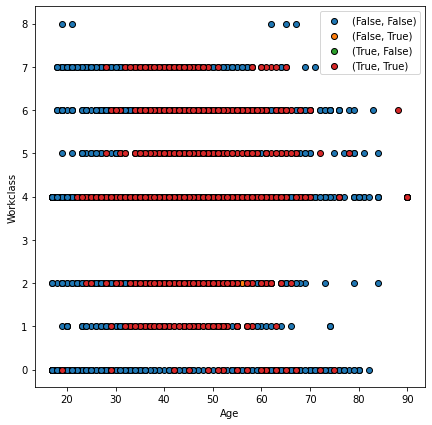

In [52]:
explain()

Again, precision of the target class is 0 on the original data set.

But in the most important rule of the fully grown tree we can find the feature Hours per week and that is needs to be very big, > 62.8. But Hours per week is given only low importance.